In [105]:
import time,json,os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.ensemble import BaggingClassifier
from common import preprocess
import seaborn as sns
from sklearn.svm import SVC
import joblib
from warnings import filterwarnings
filterwarnings("ignore") 
np.set_printoptions(suppress=True)
pd.set_option('display.float_format',lambda x : '%.8f' % x)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
plt.style.use({'figure.figsize':(12, 4)})

In [106]:
def show_heatmap(df):
    plt.style.use({'figure.figsize':(16, 6)})
    plt.ticklabel_format(style='plain',axis='both')
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    return sns.heatmap(df, cmap = cmap, linewidths = 0.05,annot=False, fmt="g",annot_kws={"fontsize":16})
    #plt.xticks(rotation=60)
    #plt.yticks(rotation=60)

In [107]:
class CJAnalyse:
    
    def __init__(self, model_name):
        self.df_similarity = pd.read_csv("/data/paper/analyse/similarity.csv",index_col=0)
        self.df_model = pd.read_csv("/data/paper/analyse/%s.csv"%model_name,index_col=0)
        self.filter_useless_fields()
        
    def get_similar(self, d1, d2):
        mask = (self.df_similarity['D1'] == "%s"%d1) & (self.df_similarity['D2'] == d2)
        ret = {}
        for D in self.df_similarity.keys():
            if D in ['D1','D2']:
                continue
            ret[D] = self.df_similarity[mask].iloc[0][D]
        return ret
    
    def filter_useless_fields(self):
        df_m = self.df_model.copy( deep = True )
        del df_m['confusion_matrix']
        del df_m['roc_curve']
        del df_m['mcc']
        del df_m['log_loss']
        del df_m['fbeta_score']
        self.df_model = df_m
        
    def Merge(self):
        all_data = []
        for item in json.loads(self.df_model.to_json(orient="records")):
            tmp = item
            tmp["train"] = item["train"]
            tmp["valid"] = item["valid"]
            similar = self.get_similar(item["train"], item['valid'])
            for s in similar:
                tmp[s] = similar[s]
            all_data.append(tmp)
        return pd.DataFrame(all_data)
    
    #pearsonr,spearmanr or kendalltau
    def Correlation(self,df, kind = "pearsonr"):
        df_merged = df.copy( deep= True )
        all_data = []
        for score in self.df_model.keys():
            if score in ['model', 'train', 'valid']:
                continue
            s1 = df_merged[score]
            metric_value = {}
            metric_value['score'] = score
            metric_list = self.df_similarity.keys()
            for metric in metric_list:
                if metric in ['D1','D2']:
                    continue
                s2 = df_merged[metric]
                if kind == 'pearsonr':
                    metric_value[metric] = scipy.stats.pearsonr(s1,s2)[0]
                if kind == 'spearmanr':
                    metric_value[metric] = scipy.stats.spearmanr(s1,s2)[0]
                if kind == 'kendalltau':
                    metric_value[metric] = scipy.stats.kendalltau(s1,s2)[0]
                metric_value[metric] = abs(metric_value[metric])
            all_data.append(metric_value)

        df_all = pd.DataFrame(all_data)
        df_all.set_index("score", inplace = True, drop = True)
        return df_all #.reset_index()

In [108]:
test = CJAnalyse("svm")
df_all = test.Merge()

# Correlations for each base set

In [110]:
df_base_set_corr = pd.DataFrame()
for train_set in ["s-0-*","s-1-*","s-2-*","s-3-*"]:
    mask = df_all.train.str.contains(r'%s'%train_set)
    df_test = df_all[mask]
    df_base_set_corr[train_set] = test.Correlation(df_test).mean()
display(df_base_set_corr.T.mean())
df_base_set_corr.T

Cosine      0.51748214
Pearson     0.51748602
Euclidean   0.52536478
EDM         0.64923883
KS          0.38752331
Manhattan   0.58347162
Minkowski   0.50098027
Jaccard     0.10717920
dtype: float64

,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
s-0-*,0.37631749,0.37627613,0.42726245,0.58235566,0.48592076,0.40215193,0.45967586,0.11958616
s-1-*,0.55130056,0.55122017,0.54261219,0.57337659,0.26143886,0.52628851,0.50409468,0.13288021
s-2-*,0.52146996,0.52152133,0.51012016,0.63306131,0.34648475,0.63218634,0.46576395,0.07306722
s-3-*,0.62084053,0.62092645,0.62146433,0.80816178,0.45624888,0.77325971,0.57438658,0.10318320


Text(0.5, 1.0, 'Correlation between Base sample and Distance')

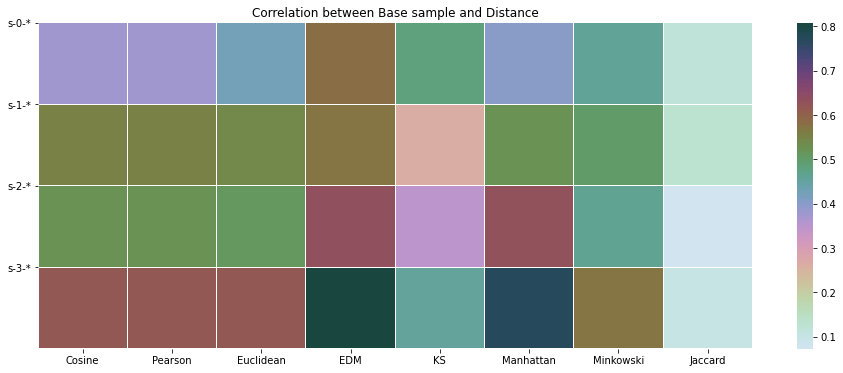

In [113]:
ax = show_heatmap(df_base_set_corr.T)
ticks = ax.set_yticks(range(len(df_base_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_base_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

Text(0.5, 1.0, 'Correlation between Base sample and Distance')

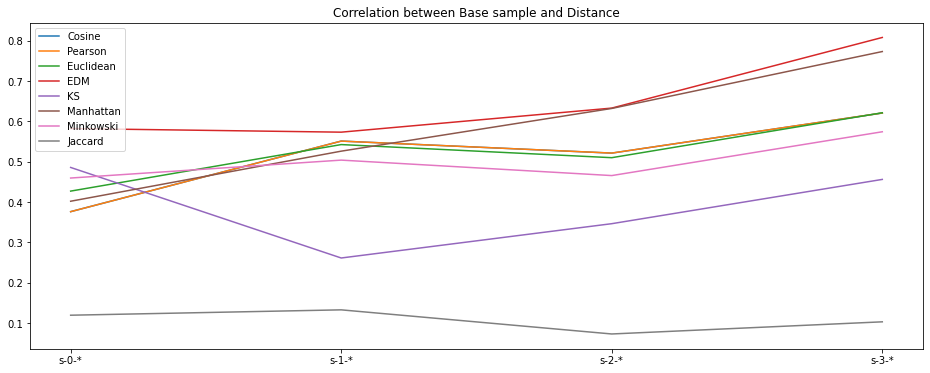

In [114]:
ax = df_base_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_base_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_base_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Base sample and Distance")

# Correlations for each train set

In [115]:
df_group = df_all.groupby("train")
df_train_set_corr = pd.DataFrame()
for train_set,df in df_group:    
    df_train_set_corr[train_set] = test.Correlation(df).mean()
print("Total mean correlation")
display(df_train_set_corr.T.mean())
df_train_set_corr.T

Total mean correlation


Cosine      0.58124293
Pearson     0.58127220
Euclidean   0.58286841
EDM         0.70471928
KS          0.39662661
Manhattan   0.65465521
Minkowski   0.55217712
Jaccard     0.11424668
dtype: float64

,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
s-0-1-0,0.37208140,0.37206111,0.43067741,0.57617384,0.47606883,0.41017464,0.45485135,0.10402129
s-0-2-0,0.37642478,0.37640326,0.43494374,0.56328009,0.47514036,0.41449661,0.45931027,0.10277209
s-0-3-0,0.43702337,0.43704732,0.48386788,0.66229164,0.52516699,0.47562271,0.51151359,0.14915951
s-0-4-0,0.43755342,0.43748826,0.48443306,0.66363638,0.55077086,0.47629240,0.51340631,0.14914439
s-1-1-0,0.72659287,0.72654741,0.71527246,0.73860088,0.37329618,0.71614224,0.68030175,0.19198272
s-1-2-0,0.75253582,0.75247264,0.72345796,0.76018775,0.38470118,0.73324972,0.65906763,0.19094580
s-1-3-0,0.78637874,0.78637276,0.73768229,0.74200642,0.16686909,0.78279925,0.66616177,0.11343481
s-1-4-0,0.74047851,0.74050209,0.69090218,0.70853105,0.14096830,0.74572249,0.63027750,0.11218721
s-2-1-0,0.53087017,0.53095268,0.51745364,0.63553362,0.32729256,0.63882285,0.46857224,0.06990442
s-2-2-0,0.52411354,0.52416294,0.50742486,0.63065154,0.36411989,0.62693540,0.46339332,0.07125932


Text(0.5, 1.0, 'Correlation between Train sample and Distance')

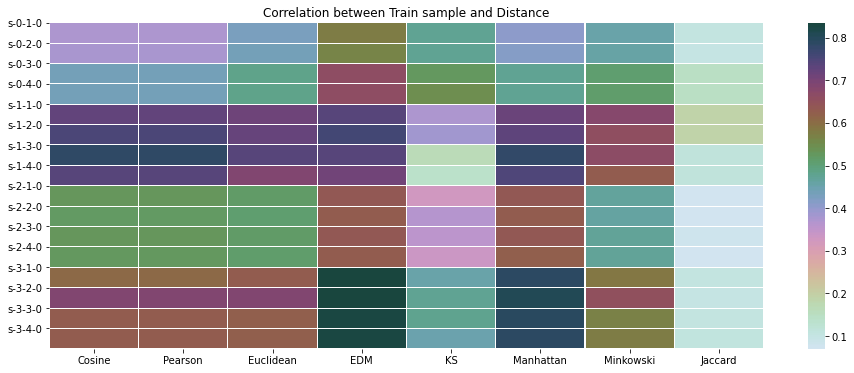

In [116]:
ax = show_heatmap(df_train_set_corr.T)
ticks = ax.set_yticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_yticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train sample and Distance")

Text(0.5, 1.0, 'Correlation between Train Dataset and Distance')

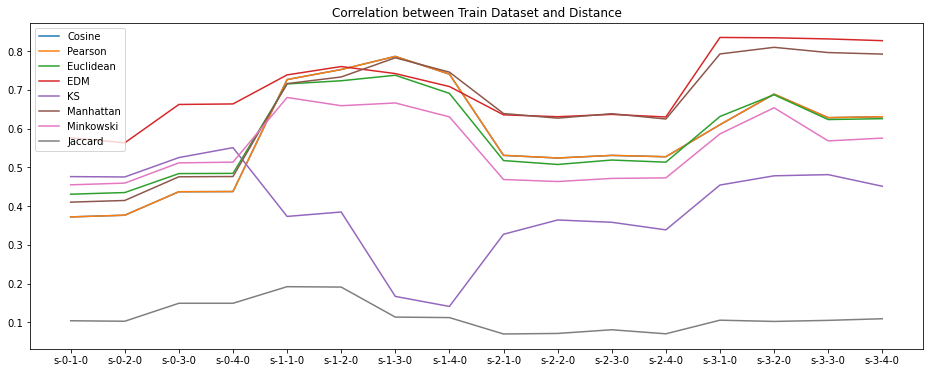

In [117]:
ax = df_train_set_corr.T.plot(kind='line')
ticks = ax.set_xticks(range(len(df_train_set_corr.T.index))) # 设置刻度
labels = ax.set_xticklabels(df_train_set_corr.T.index,rotation = 0 ) # 设置刻度标签
ax.set_title("Correlation between Train Dataset and Distance")

# Detail correlation for each train set

In [118]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Mean correlation for train set ", train_set)
    display ( corr.mean() )

Mean correlation for train set  s-0-1-0


Cosine      0.37208140
Pearson     0.37206111
Euclidean   0.43067741
EDM         0.57617384
KS          0.47606883
Manhattan   0.41017464
Minkowski   0.45485135
Jaccard     0.10402129
dtype: float64

Mean correlation for train set  s-0-2-0


Cosine      0.37642478
Pearson     0.37640326
Euclidean   0.43494374
EDM         0.56328009
KS          0.47514036
Manhattan   0.41449661
Minkowski   0.45931027
Jaccard     0.10277209
dtype: float64

Mean correlation for train set  s-0-3-0


Cosine      0.43702337
Pearson     0.43704732
Euclidean   0.48386788
EDM         0.66229164
KS          0.52516699
Manhattan   0.47562271
Minkowski   0.51151359
Jaccard     0.14915951
dtype: float64

Mean correlation for train set  s-0-4-0


Cosine      0.43755342
Pearson     0.43748826
Euclidean   0.48443306
EDM         0.66363638
KS          0.55077086
Manhattan   0.47629240
Minkowski   0.51340631
Jaccard     0.14914439
dtype: float64

Mean correlation for train set  s-1-1-0


Cosine      0.72659287
Pearson     0.72654741
Euclidean   0.71527246
EDM         0.73860088
KS          0.37329618
Manhattan   0.71614224
Minkowski   0.68030175
Jaccard     0.19198272
dtype: float64

Mean correlation for train set  s-1-2-0


Cosine      0.75253582
Pearson     0.75247264
Euclidean   0.72345796
EDM         0.76018775
KS          0.38470118
Manhattan   0.73324972
Minkowski   0.65906763
Jaccard     0.19094580
dtype: float64

Mean correlation for train set  s-1-3-0


Cosine      0.78637874
Pearson     0.78637276
Euclidean   0.73768229
EDM         0.74200642
KS          0.16686909
Manhattan   0.78279925
Minkowski   0.66616177
Jaccard     0.11343481
dtype: float64

Mean correlation for train set  s-1-4-0


Cosine      0.74047851
Pearson     0.74050209
Euclidean   0.69090218
EDM         0.70853105
KS          0.14096830
Manhattan   0.74572249
Minkowski   0.63027750
Jaccard     0.11218721
dtype: float64

Mean correlation for train set  s-2-1-0


Cosine      0.53087017
Pearson     0.53095268
Euclidean   0.51745364
EDM         0.63553362
KS          0.32729256
Manhattan   0.63882285
Minkowski   0.46857224
Jaccard     0.06990442
dtype: float64

Mean correlation for train set  s-2-2-0


Cosine      0.52411354
Pearson     0.52416294
Euclidean   0.50742486
EDM         0.63065154
KS          0.36411989
Manhattan   0.62693540
Minkowski   0.46339332
Jaccard     0.07125932
dtype: float64

Mean correlation for train set  s-2-3-0


Cosine      0.53078014
Pearson     0.53086243
Euclidean   0.51883899
EDM         0.63664682
KS          0.35816374
Manhattan   0.63845165
Minkowski   0.47142812
Jaccard     0.08079201
dtype: float64

Mean correlation for train set  s-2-4-0


Cosine      0.52736568
Pearson     0.52741623
Euclidean   0.51335336
EDM         0.62996931
KS          0.33863904
Manhattan   0.62474526
Minkowski   0.47277938
Jaccard     0.07035785
dtype: float64

Mean correlation for train set  s-3-1-0


Cosine      0.61000526
Pearson     0.61007913
Euclidean   0.63123841
EDM         0.83521556
KS          0.45430989
Manhattan   0.79270798
Minkowski   0.58632057
Jaccard     0.10548298
dtype: float64

Mean correlation for train set  s-3-2-0


Cosine      0.68896658
Pearson     0.68905203
Euclidean   0.68740066
EDM         0.83436901
KS          0.47815090
Manhattan   0.80975812
Minkowski   0.65375982
Jaccard     0.10227895
dtype: float64

Mean correlation for train set  s-3-3-0


Cosine      0.62819745
Pearson     0.62830789
Euclidean   0.62335703
EDM         0.83146726
KS          0.48117000
Manhattan   0.79625577
Minkowski   0.56824848
Jaccard     0.10499452
dtype: float64

Mean correlation for train set  s-3-4-0


Cosine      0.63051907
Pearson     0.63062706
Euclidean   0.62559062
EDM         0.82694722
KS          0.45119789
Manhattan   0.79230622
Minkowski   0.57544173
Jaccard     0.10922908
dtype: float64

In [119]:
df_group = df_all.groupby("train")
for train_set, df in df_group:
    mask = (df_all.train == train_set)
    df_test = df_all[mask]
    corr = test.Correlation(df_test)
    print("Detail correlation for train set ", train_set)
    display ( corr )

Detail correlation for train set  s-0-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.47918537,0.47933547,0.38727769,0.05386956,0.20042412,0.43166966,0.33727723,0.04270186
accuracy,0.28290683,0.28269328,0.43689185,0.81641512,0.60834353,0.39078052,0.49479744,0.14853426
precision,0.11721693,0.11698976,0.28098479,0.71657307,0.46047210,0.23008886,0.34770278,0.08389884
auc,0.94399820,0.94396665,0.93122014,0.71298828,0.79836220,0.93438283,0.91137305,0.18536007
f1_score,0.03709968,0.03732040,0.11701256,0.58102316,0.31274220,0.06395132,0.18310627,0.05961144


Detail correlation for train set  s-0-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.49605732,0.49619796,0.41317137,0.00990667,0.23314286,0.45536001,0.36635467,0.05372431
accuracy,0.28428944,0.28407593,0.43708513,0.81301344,0.59930319,0.39152128,0.49454918,0.14421497
precision,0.11658692,0.11635875,0.28013101,0.71440420,0.45449558,0.22969899,0.34678260,0.07968411
auc,0.94627090,0.94624336,0.93013230,0.70345048,0.78330590,0.93424281,0.90889637,0.18151475
f1_score,0.03891932,0.03914032,0.11419890,0.57562568,0.30545427,0.06165998,0.17996854,0.05472229


Detail correlation for train set  s-0-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.83455280,0.83442981,0.93246529,0.94707871,0.83140782,0.91897848,0.95488431,0.21876451
accuracy,0.16811859,0.16789855,0.33670818,0.70720723,0.46767754,0.29370124,0.40370948,0.12352939
precision,0.00018848,0.00041133,0.19402976,0.64090718,0.45616130,0.13602610,0.27584662,0.14993250
auc,0.97431887,0.97434956,0.92042941,0.57777001,0.63153743,0.93649510,0.88101196,0.16816857
f1_score,0.20793810,0.20814737,0.03570678,0.43849510,0.23905085,0.09291263,0.04211556,0.08540260


Detail correlation for train set  s-0-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.83436216,0.83423931,0.93234403,0.94758928,0.88314756,0.91892049,0.95488339,0.22004176
accuracy,0.17007592,0.16985616,0.33836089,0.70696560,0.50043984,0.29571248,0.40530891,0.12298766
precision,0.00410279,0.00387975,0.19829873,0.64302418,0.46222567,0.14061806,0.28006690,0.14899276
auc,0.97457255,0.97460286,0.92080504,0.58057020,0.66973240,0.93690574,0.88127835,0.16907772
f1_score,0.20465366,0.20486322,0.03235662,0.44003266,0.23830885,0.08930524,0.04549399,0.08462207


Detail correlation for train set  s-1-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.62020076,0.62041375,0.53623977,0.57569490,0.07711481,0.69369096,0.47153315,0.05896249
accuracy,0.70264829,0.70242363,0.74989367,0.77640712,0.56119729,0.63688032,0.74296872,0.28044088
precision,0.72451636,0.72430409,0.76705606,0.79328899,0.55747508,0.66249342,0.75706399,0.27887195
auc,0.87503465,0.87523413,0.77921924,0.80027272,0.17785282,0.93737533,0.70013500,0.09459915
f1_score,0.71056431,0.71036142,0.74395356,0.74734066,0.49284088,0.65027116,0.72980790,0.24703912


Detail correlation for train set  s-1-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.77470357,0.77495142,0.68564354,0.68728892,0.13031365,0.84986106,0.58644387,0.05683573
accuracy,0.68782627,0.68754408,0.70534317,0.78212748,0.56455574,0.60347197,0.67029815,0.27974938
precision,0.71942302,0.71916095,0.73155067,0.80439859,0.55976470,0.64083246,0.69159079,0.27778660
auc,0.87576038,0.87599310,0.78520529,0.77227247,0.17428944,0.94375162,0.68109287,0.09451476
f1_score,0.70496586,0.70471367,0.70954711,0.75485132,0.49458235,0.62833150,0.66591246,0.24584252


Detail correlation for train set  s-1-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.88349859,0.88365709,0.80117782,0.90660799,0.18543003,0.93667547,0.70249732,0.09261975
accuracy,0.70580861,0.70565261,0.69344429,0.58402117,0.18677453,0.65121725,0.65213452,0.16677718
precision,0.66250571,0.66234681,0.65355235,0.57389012,0.15463788,0.60437797,0.61344942,0.13843940
auc,0.80689686,0.80708485,0.70605128,0.83084328,0.09669938,0.86918858,0.60025537,0.01700441
f1_score,0.87318394,0.87312247,0.83418570,0.81466952,0.21080362,0.85253698,0.76247222,0.15233333


Detail correlation for train set  s-1-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.83502170,0.83521144,0.74193235,0.86888716,0.17163388,0.90317586,0.65102597,0.09912847
accuracy,0.80985871,0.80974733,0.79257122,0.69305354,0.15878704,0.76009481,0.74995558,0.15356368
precision,0.72471145,0.72456494,0.72328180,0.62399308,0.16696167,0.66316397,0.69155674,0.14366590
auc,0.52748260,0.52776469,0.41014369,0.62233414,0.00675819,0.63549491,0.31914803,0.00950965
f1_score,0.80531809,0.80522205,0.78658184,0.73438733,0.20070069,0.76668289,0.73970120,0.15506834


Detail correlation for train set  s-2-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.62844171,0.62860603,0.60489052,0.89802226,0.35360735,0.85406252,0.53557782,0.07723150
accuracy,0.03622172,0.03629749,0.05367157,0.24005578,0.07768056,0.21144519,0.05657107,0.04747802
precision,0.61722845,0.61723846,0.57557103,0.46369478,0.30530343,0.55052898,0.50872484,0.01638142
auc,0.91562026,0.91561557,0.90537877,0.78226817,0.61955597,0.86016608,0.84355469,0.12727012
f1_score,0.45683873,0.45700587,0.44775632,0.79362712,0.28031548,0.71791149,0.39843276,0.08116105


Detail correlation for train set  s-2-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.57785014,0.57801630,0.56992150,0.89804078,0.39907391,0.83190991,0.50893365,0.07769256
accuracy,0.04155599,0.04147334,0.01129063,0.23029455,0.09108281,0.16360562,0.00782061,0.04822677
precision,0.69014937,0.69015620,0.65425349,0.49358858,0.33665293,0.61326311,0.59738013,0.01617483
auc,0.93438104,0.93436426,0.92062414,0.74031725,0.67113276,0.84889453,0.86683120,0.13129453
f1_score,0.37663115,0.37680459,0.38103453,0.79101652,0.32265704,0.67700384,0.33600104,0.08290792


Detail correlation for train set  s-2-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.62726129,0.62742591,0.60482189,0.89819300,0.38444557,0.85332130,0.53733236,0.08920354
accuracy,0.03211063,0.03218311,0.05072899,0.23216672,0.05382055,0.20317093,0.05449293,0.05784412
precision,0.64234743,0.64236685,0.60089259,0.50556864,0.40183229,0.58862757,0.53319977,0.01676253
auc,0.90090919,0.90089684,0.89444006,0.75634765,0.67055671,0.83362289,0.83636851,0.14390132
f1_score,0.45127217,0.45143942,0.44331145,0.79095807,0.28016358,0.71351558,0.39574705,0.09624856


Detail correlation for train set  s-2-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.57565906,0.57582519,0.57051488,0.89738849,0.37211147,0.82966351,0.51373849,0.07640847
accuracy,0.05717648,0.05709664,0.02785353,0.21094521,0.03549293,0.14383058,0.02377836,0.04615234
precision,0.70620543,0.70621937,0.67538808,0.52874032,0.39345588,0.64225241,0.62271457,0.01881819
auc,0.93181371,0.93179305,0.92118100,0.72962691,0.62384075,0.84141426,0.87397215,0.12865276
f1_score,0.36597371,0.36614687,0.37182930,0.78314562,0.26829417,0.66656554,0.32969330,0.08175748


Detail correlation for train set  s-3-1-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.64695632,0.64705115,0.67532146,0.97390361,0.48237322,0.89062175,0.62534055,0.10158423
accuracy,0.75029798,0.75026678,0.72695460,0.35928790,0.51288177,0.59230079,0.68490205,0.16603326
precision,0.41769329,0.41780369,0.45911873,0.90510459,0.34609876,0.73496212,0.42370312,0.06672384
auc,0.64095851,0.64105399,0.66908822,0.97268371,0.47894022,0.88686367,0.61892132,0.10037977
f1_score,0.59412018,0.59422001,0.62570905,0.96509801,0.45125548,0.85879158,0.57873582,0.09269380


Detail correlation for train set  s-3-2-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.74743181,0.74754588,0.74644262,0.97063938,0.50441327,0.91415819,0.70969804,0.09736370
accuracy,0.69693353,0.69686776,0.68726971,0.36604863,0.54887153,0.55677939,0.65589523,0.16784707
precision,0.55513220,0.55527389,0.55921208,0.90541247,0.36791925,0.78087032,0.53078936,0.06279625
auc,0.74221267,0.74232773,0.74102672,0.96909825,0.49821107,0.91070553,0.70433712,0.09537196
f1_score,0.70312271,0.70324488,0.70305218,0.96064631,0.47133936,0.88627717,0.66807936,0.08801578


Detail correlation for train set  s-3-3-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.62505030,0.62520480,0.60993236,0.92489949,0.46322656,0.85654299,0.54266414,0.08687882
accuracy,0.71531837,0.71530036,0.71956547,0.57182701,0.59203817,0.66741220,0.67819468,0.12736826
precision,0.45540220,0.45555409,0.45527018,0.80650498,0.33420820,0.71081871,0.41105295,0.08911101
auc,0.79398584,0.79409486,0.78660335,0.97112617,0.60694107,0.94789649,0.71916033,0.12842368
f1_score,0.55123054,0.55138531,0.54541380,0.88297866,0.40943600,0.79860847,0.49017033,0.09319082


Detail correlation for train set  s-3-4-0


,Cosine,Pearson,Euclidean,EDM,KS,Manhattan,Minkowski,Jaccard
score,,,,,,,,
recall,0.65099754,0.65114597,0.63313596,0.92377880,0.45573779,0.86584445,0.56756605,0.08244487
accuracy,0.70256708,0.70254971,0.70412103,0.57693207,0.55066560,0.66132476,0.66486181,0.14327469
precision,0.44127342,0.44142407,0.44508223,0.78827558,0.29154584,0.69205711,0.41002937,0.09351254
auc,0.79952082,0.79962645,0.79269607,0.96705741,0.57447773,0.94463541,0.73181752,0.13215513
f1_score,0.55823651,0.55838912,0.55291778,0.87869227,0.38356247,0.79766936,0.50293392,0.09475816


# Distribution by Score and distance

In [120]:
def get_distribution( df, metric = "EDM", degree = 9 ):
    df_test = df[[metric,'train','valid','recall', 'accuracy', 'precision', 'auc', 'f1_score']]
    df_test[metric] = ( df_test[metric] - df_test[metric].mean() ) / ( df_test[metric].max()-df_test[metric].min() ) 
    df_t = df_test.sort_values(by=metric)
    for key in [metric,'recall', 'accuracy', 'precision', 'auc', 'f1_score']:
        cate = pd.qcut( df_t[key], degree, labels=False, duplicates='drop', precision=8)
        cate.fillna(-1,inplace=True)
        df_t[key] = cate
    df_dis = pd.DataFrame()
    all_data = []
    for d,df in df_t.groupby(metric):
        del df['train']
        del df['valid']
        del df[metric]
        pd_keys = df.keys()
        pd_keys.sort_values()
        for item in pd_keys:
            tmp = {}
            tmp['Distance'] = d
            tmp['Score'] = item
            jdata = json.loads(df[item].value_counts().to_json())
            json_keys = list(jdata.keys())
            json_keys.sort()
            for key in json_keys:
                value = jdata[key]
                tmp["level-%s"%key] = int(value)
            all_data.append( tmp )
    df_dis = pd.DataFrame(all_data).fillna(0)
    for i in range(len(df_t[metric].unique())):
        key = "level-%d"%i
        df_dis[key] = df_dis[key].astype(int)
    return df_dis

In [121]:
df_dis = get_distribution(df_all ,metric = 'EDM', degree = 5 )
df_dis.head(5)

,Distance,Score,level-0,level-1,level-2,level-3,level-4
0,0,recall,12,69,51,60,13
1,0,accuracy,0,0,5,142,58
2,0,precision,0,4,88,77,36
3,0,auc,13,0,12,54,126
4,0,f1_score,0,24,48,100,33


Distance             0   1   2   3    4
        Score                          
level-0 accuracy     0   8  69  74   54
        auc         13  17  67  50   58
        f1_score     0   0  18  73  114
        precision    0  33  32  42   98
        recall      12  32  18  50   94
level-1 accuracy     0  28  58  39   80
        auc          0  13  38  86   68
        f1_score    24  80  36  25   40
        precision    4  27  53  55   67
        recall      69  48  28  22   37
level-2 accuracy     5  94  30  52   23
        auc         12  31  59  41   61
        f1_score    48  28  70  15   43
        precision   88  51  26  30    8
        recall      51  56  33  28   39
level-3 accuracy   142  15   0   0   48
        auc         54  69  36  28   18
        f1_score   100  34  24  39    8
        precision   77  28  28  40   32
        recall      60  46  48  39    9
level-4 accuracy    58  60  47  40    0
        auc        126  75   4   0    0
        f1_score    33  63  56  53    0
        precision   36  66  65  38    0
        recall      13  23  77  66   26

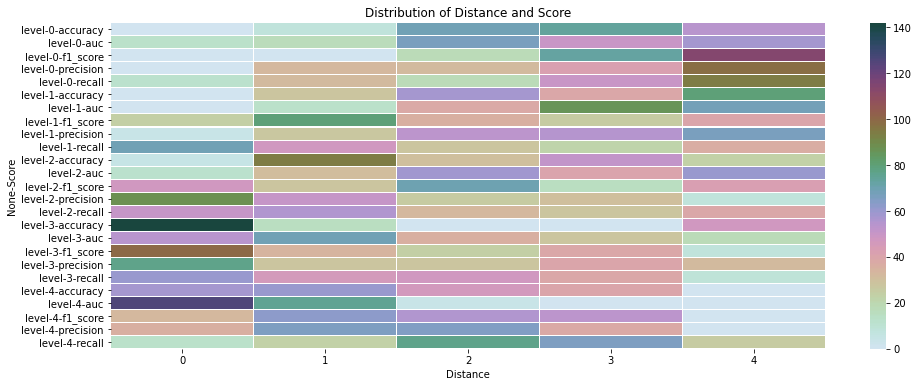

In [122]:
pt = df_dis.pivot_table(index='Distance', columns=['Score'] ,aggfunc=np.sum)
ax = show_heatmap(pt.T)
ax.set_title("Distribution of Distance and Score")
pt.T